# Heavy class overlap

This notebook's goal is to evaluate class overlap, size it and study how to mitigate its impact. To do so, three elements are assesed:

1. Visualization of the overlap
2. Quantification of the overlap
3. Strategies to deal with the overlap

In [37]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import KMeans
from scipy.spatial.distance import squareform
from mpl_toolkits.mplot3d import Axes3D
import gower
import prince
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, recall_score, roc_auc_score, roc_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from collections import Counter
from typing import List
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline
from tqdm import tqdm
from scipy.spatial.distance import euclidean, hamming
from sklearn.metrics import pairwise_distances


# import from custom package
from auxFuns.EDA import *
from auxFuns.modelling import *
from auxFuns.class_overlap import *

In [36]:
import auxFuns.EDA 
importlib.reload(auxFuns.EDA)

import auxFuns.modelling
importlib.reload(auxFuns.modelling)

import auxFuns.class_overlap
importlib.reload(auxFuns.class_overlap)

<module 'auxFuns.class_overlap' from 'c:\\Users\\angel\\Documents\\VSCode\\rsv_modelling_transfer_learning\\auxFuns\\class_overlap.py'>

In [4]:
# Load of the data and filter in the needed features

raw_datasets_path = os.getcwd() + '/datasets/raw'
processed_datasets_path = os.getcwd() + '/datasets/processed'

rsv_predictors_df_v2 = pd.read_csv(processed_datasets_path + '/rsv_predictors_phase1_daysDedup_seasons_prevTest_v2.csv',low_memory=False)
rsv_predictors_df_v2 = make_it_categorical_v2(rsv_predictors_df_v2)

In [5]:
selected_features = ['sex', 'marital_status', 'race','patient_regional_location', 'age_group',
                     'Acute_upper_respiratory_infection','Influenza','Pneumonia','Bronchitis','Symptoms_and_signs__digestive_system_and_abdomen','General_symptoms_and_signs','any_symptom',
                     'COPD','AIDS','Asthma_chronic','CCI',
                     'sine','cosine','calendar_year', 
                     'healthcare_seeking', 'influenza_vaccine',
                     'n_symptoms','prev_positive_rsv','previous_test_daydiff','n_immunodeficiencies', 
                     'tumor_indicator','tumor_last_year',
                     'season',
                     'n_tests_that_day']
selected_features_v1 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'season','multiple_tests']
selected_features_v2 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'key_comorbidities','Pneumonia',
                     'season','month_of_the_test','multiple_tests',
                     'BPA','BPAI']
selected_features_v3 = selected_features_v2 + ['race', 'age_group','marital_status','sex',
                                                    'patient_regional_location','calendar_year']

selected_features_v1.append('RSV_test_result')
selected_features_v2.append('RSV_test_result')
selected_features_v3.append('RSV_test_result')

In [6]:
df1 = rsv_predictors_df_v2[selected_features_v2]
df1 = df1.drop(['month_of_the_test'], axis = 1)
df1.shape, df1.columns

((86058, 20),
 Index(['n_tests_that_day', 'sine', 'cosine', 'previous_test_daydiff',
        'Bronchitis', 'CCI', 'Acute_upper_respiratory_infection',
        'n_immunodeficiencies', 'n_symptoms', 'healthcare_seeking',
        'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
        'key_comorbidities', 'Pneumonia', 'season', 'multiple_tests', 'BPA',
        'BPAI', 'RSV_test_result'],
       dtype='object'))

# 1. Visualization of heavy class overlap

In [7]:
random_seed = 42
n_components = 5

X = df1.drop(['RSV_test_result'], axis = 1)

famd = prince.FAMD(n_components=n_components, random_state=random_seed)
famd = famd.fit(X)

X_transformed = famd.transform(X)

df_transformed = X_transformed.copy()
# Ensure both df1 and df_transformed present the same records in the same order
df1 = df1.sort_index()
df_transformed = df_transformed.sort_index()

assert all(df1.index == df_transformed.index), "The indices of df1 and df_transformed do not match."

df_transformed['RSV_test_result'] = [1 if label == 'Positive' else 0 for label in df1['RSV_test_result']]

In [8]:
# SMOTE resampling to allow class overlap visualization
df_modelling = df_transformed[[0,1,2,3,4,'RSV_test_result']]

X = df_modelling.drop(['RSV_test_result'], axis=1)
y = df_modelling['RSV_test_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Defining the pipeline
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.1)
steps = [('o', over), ('u', under)]
pipeline = imbPipeline(steps=steps)

# Over sampled and undersampled data generation
X_train, y_train = pipeline.fit_resample(X_train, y_train)

data_smote = pd.concat([X_train, y_train], axis = 1)

y_train.value_counts()


RSV_test_result
0    66720
1     6672
Name: count, dtype: int64

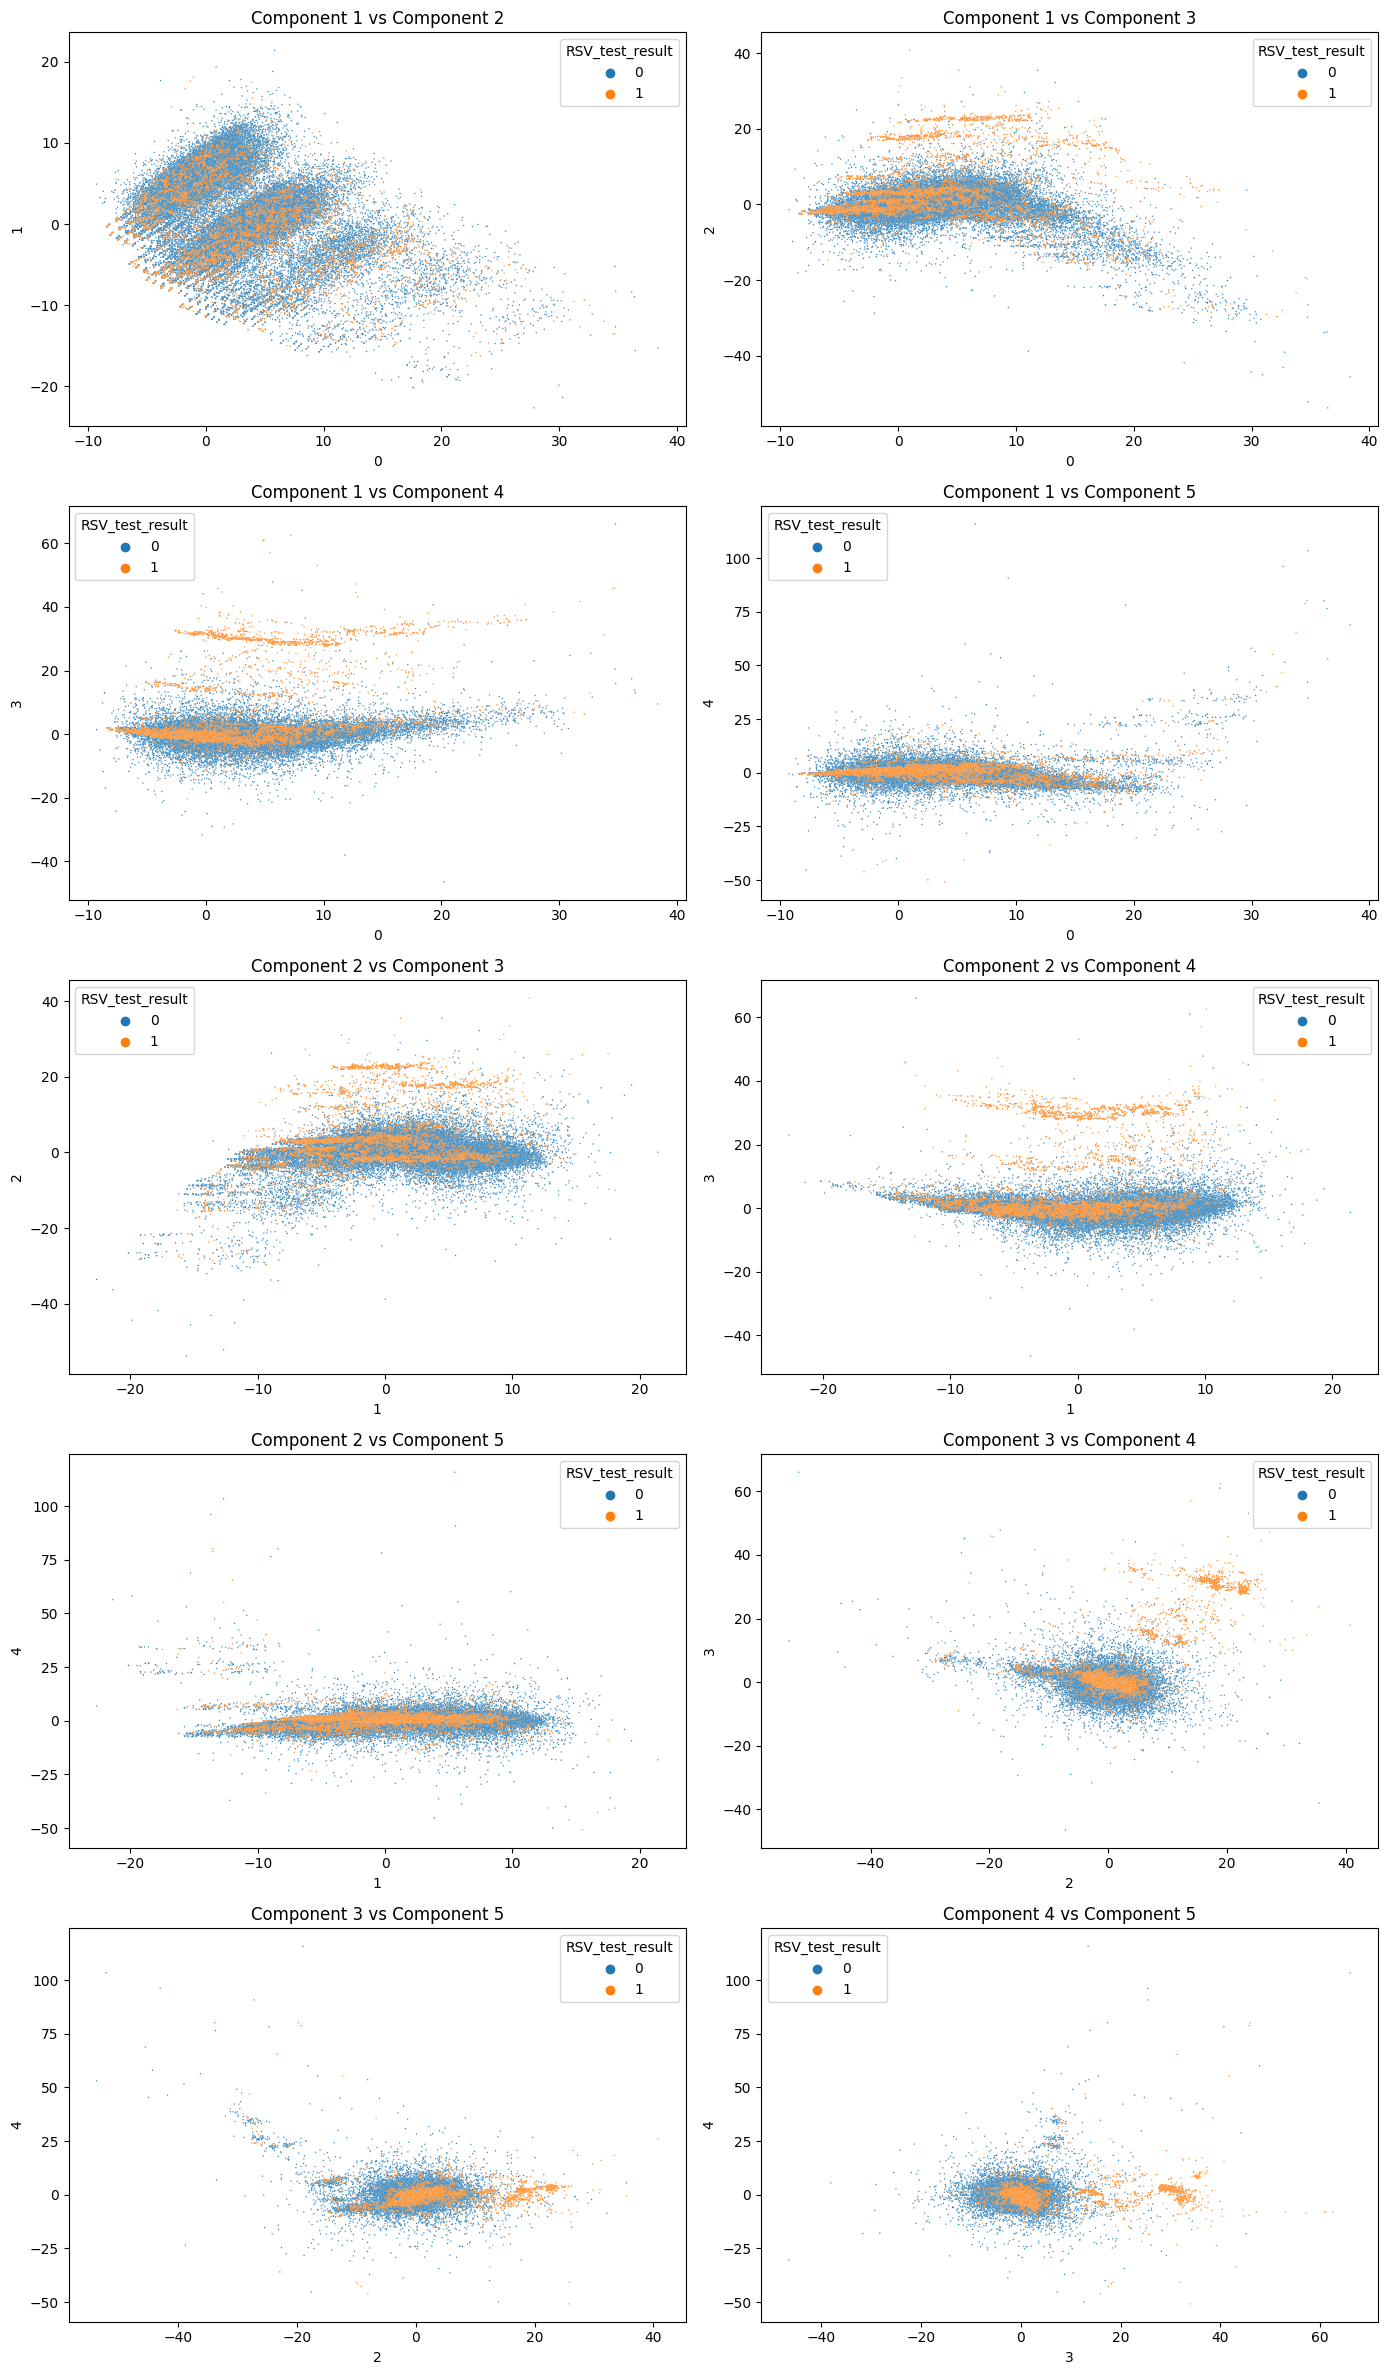

In [38]:
plot_5FMDA_planes(df = data_smote, hue_target = 'RSV_test_result')

We observe a heavy overlap between positive and negative samples. Together with this overlap, there seems to be a region where positive records prevail. 

# 2. Quantification of the overlap

To quantify the overlap, there are three approaches to follow [2]:
- Statistical distance
- Geometrical distance
- Graph-based distance

[2] Santos, M. S., Abreu, P. H., Japkowicz, N., Fernández, A., & Santos, J. (2023). A unifying view of class overlap and imbalance: Key concepts, multi-view panorama, and open avenues for research. Information Fusion, 89, 228-253.

## 2.1 Geometrical distance

Taking the FAMD transformed data, to allow the use of Euclidian distances, implementation of algorithm 1 of [3] to identify an uncertainty region, together with a positive and negative region.

[3] Vorraboot, P., Rasmequan, S., Chinnasarn, K., & Lursinsap, C. (2015). Improving classification rate constrained to imbalanced data between overlapped and non-overlapped regions by hybrid algorithms. Neurocomputing, 152, 429-443.

In [ ]:
df_positives = df_transformed.loc[ df_transformed.RSV_test_result == 1, [0,1,2,3,4]]
df_negatives = df_transformed.loc[df_transformed.RSV_test_result == 0, [0,1,2,3,4]]

Z, U = find_non_overlap_fast(df_positives, df_negatives, euclidean)
print("Non-overlapping data (Z): ", Z)
print("Uncertain data (U): ", U)

The build-up of distance matrices is very expensive in computing power. An alternative method for geometrical distance computation can be done using DBSCAN

In [35]:
eps_value = 1
min_samples_value = 5

db = DBSCAN(eps = eps_value, min_samples = min_samples_value).fit(df_transformed[[0, 1, 2, 3, 4]]) 
labels = db.labels_
df_transformed['DBSCAN_labels'] = labels

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')

Estimated number of clusters: 167
Estimated number of noise points: 19949


-----------
Total number of positive records: 2654
Number of positives in Clustered: 1713
Number of positives in Noise: 941


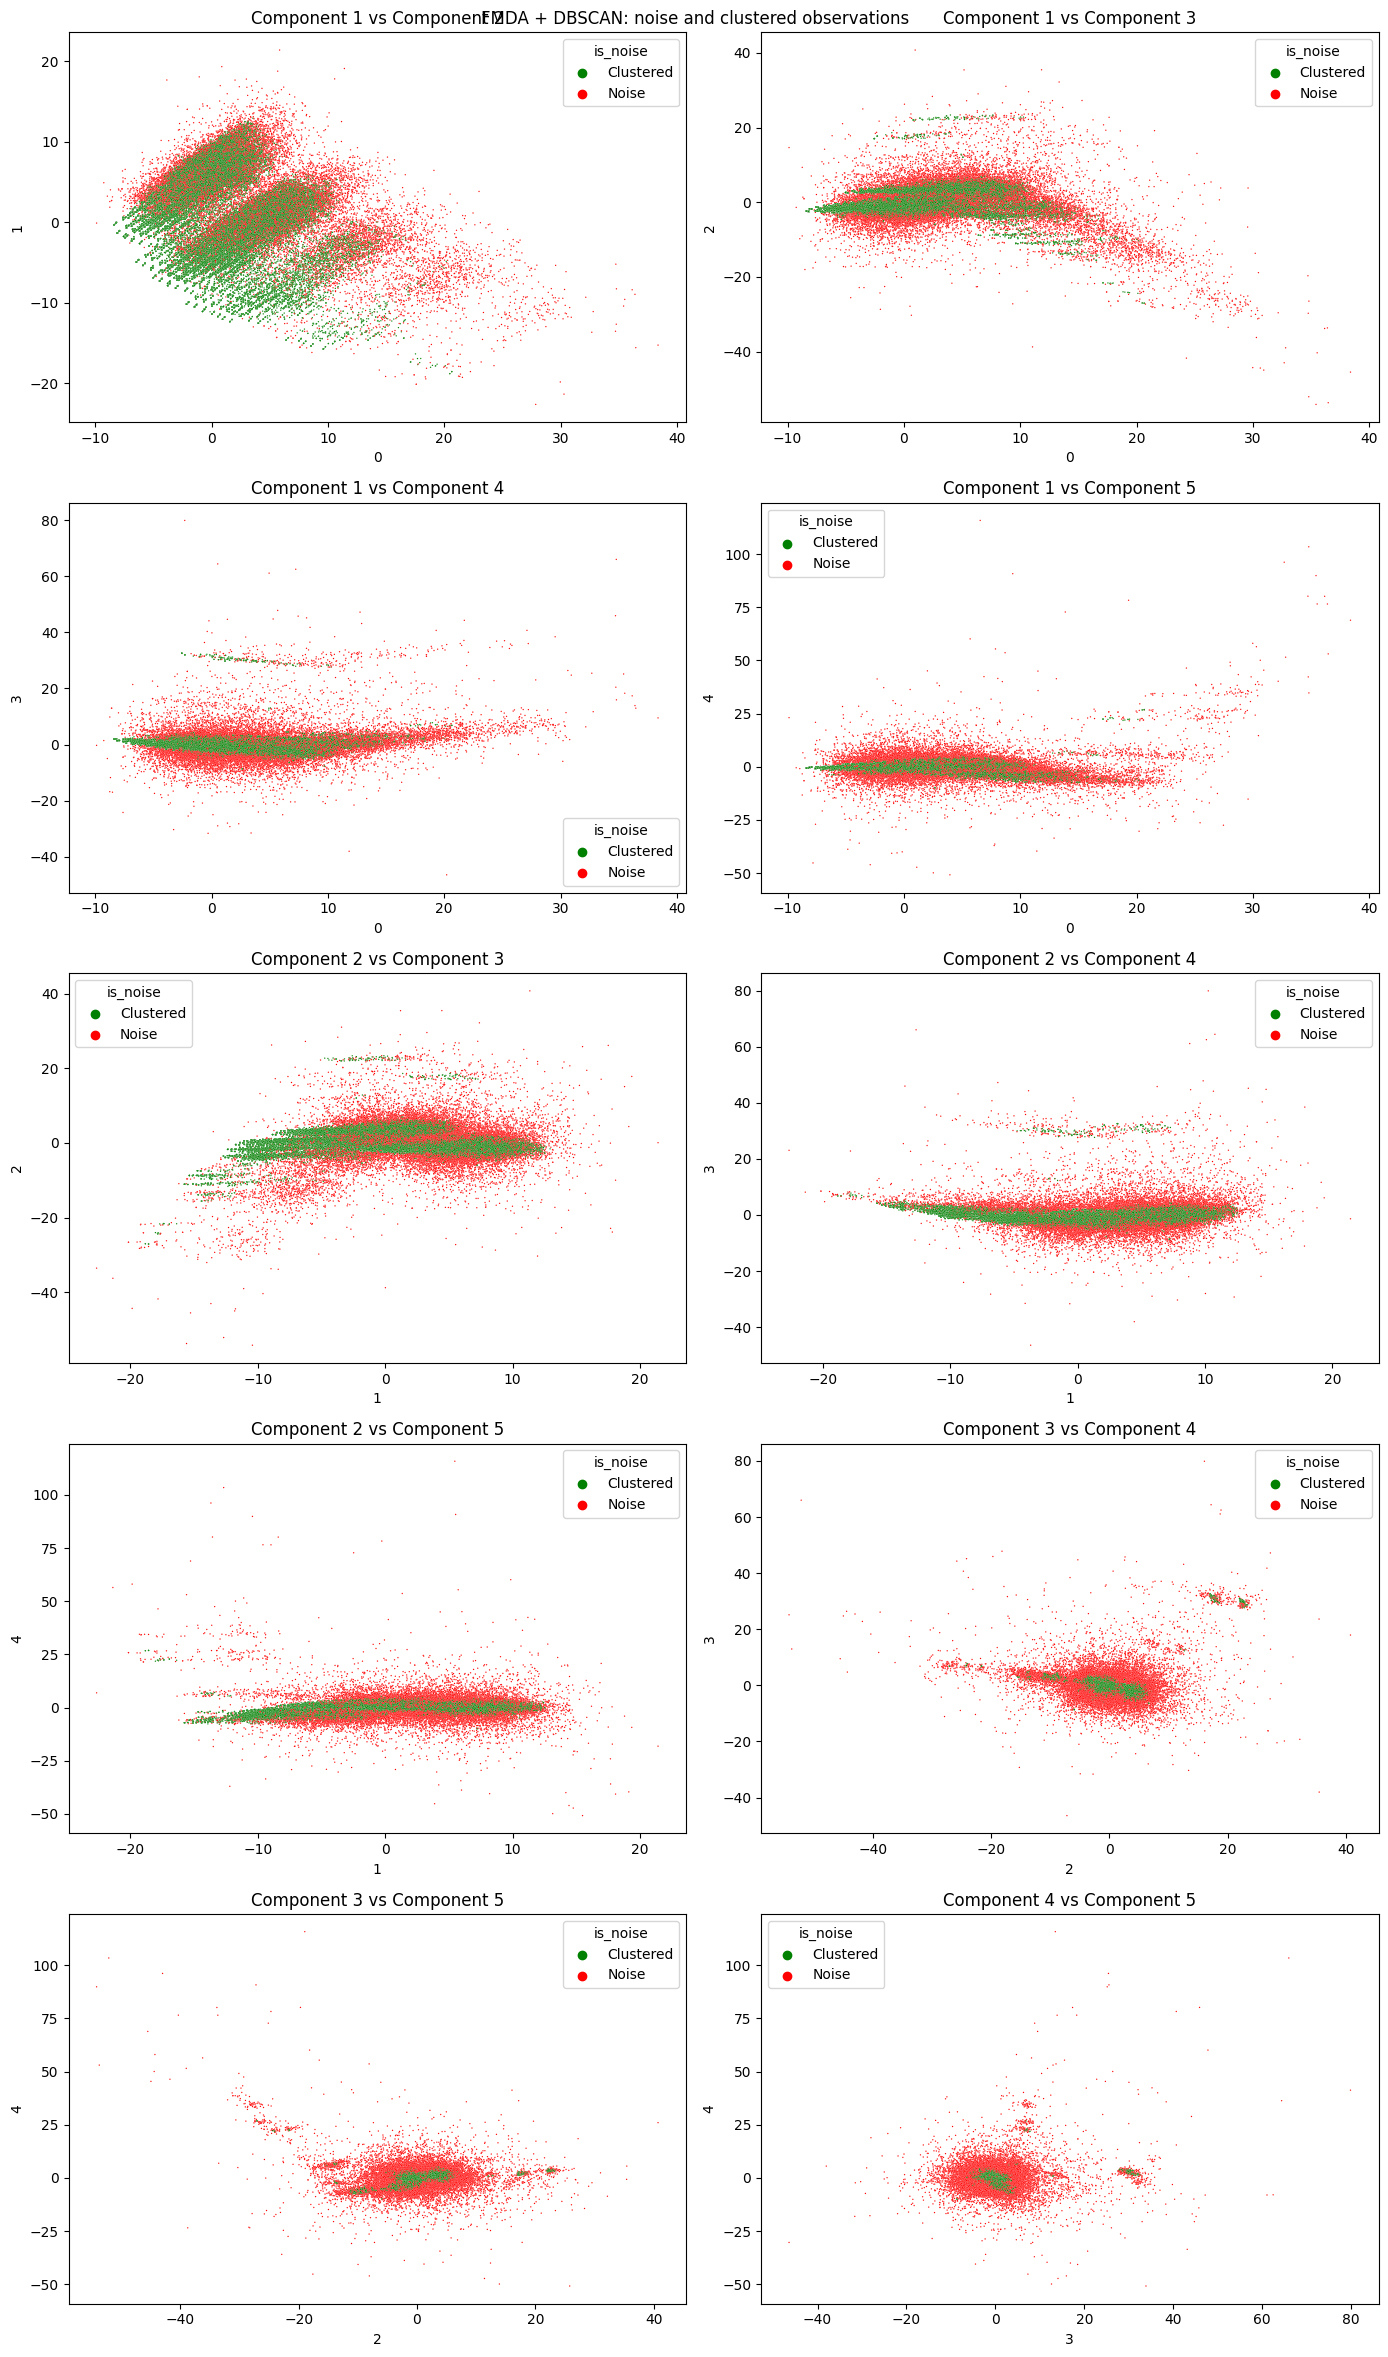

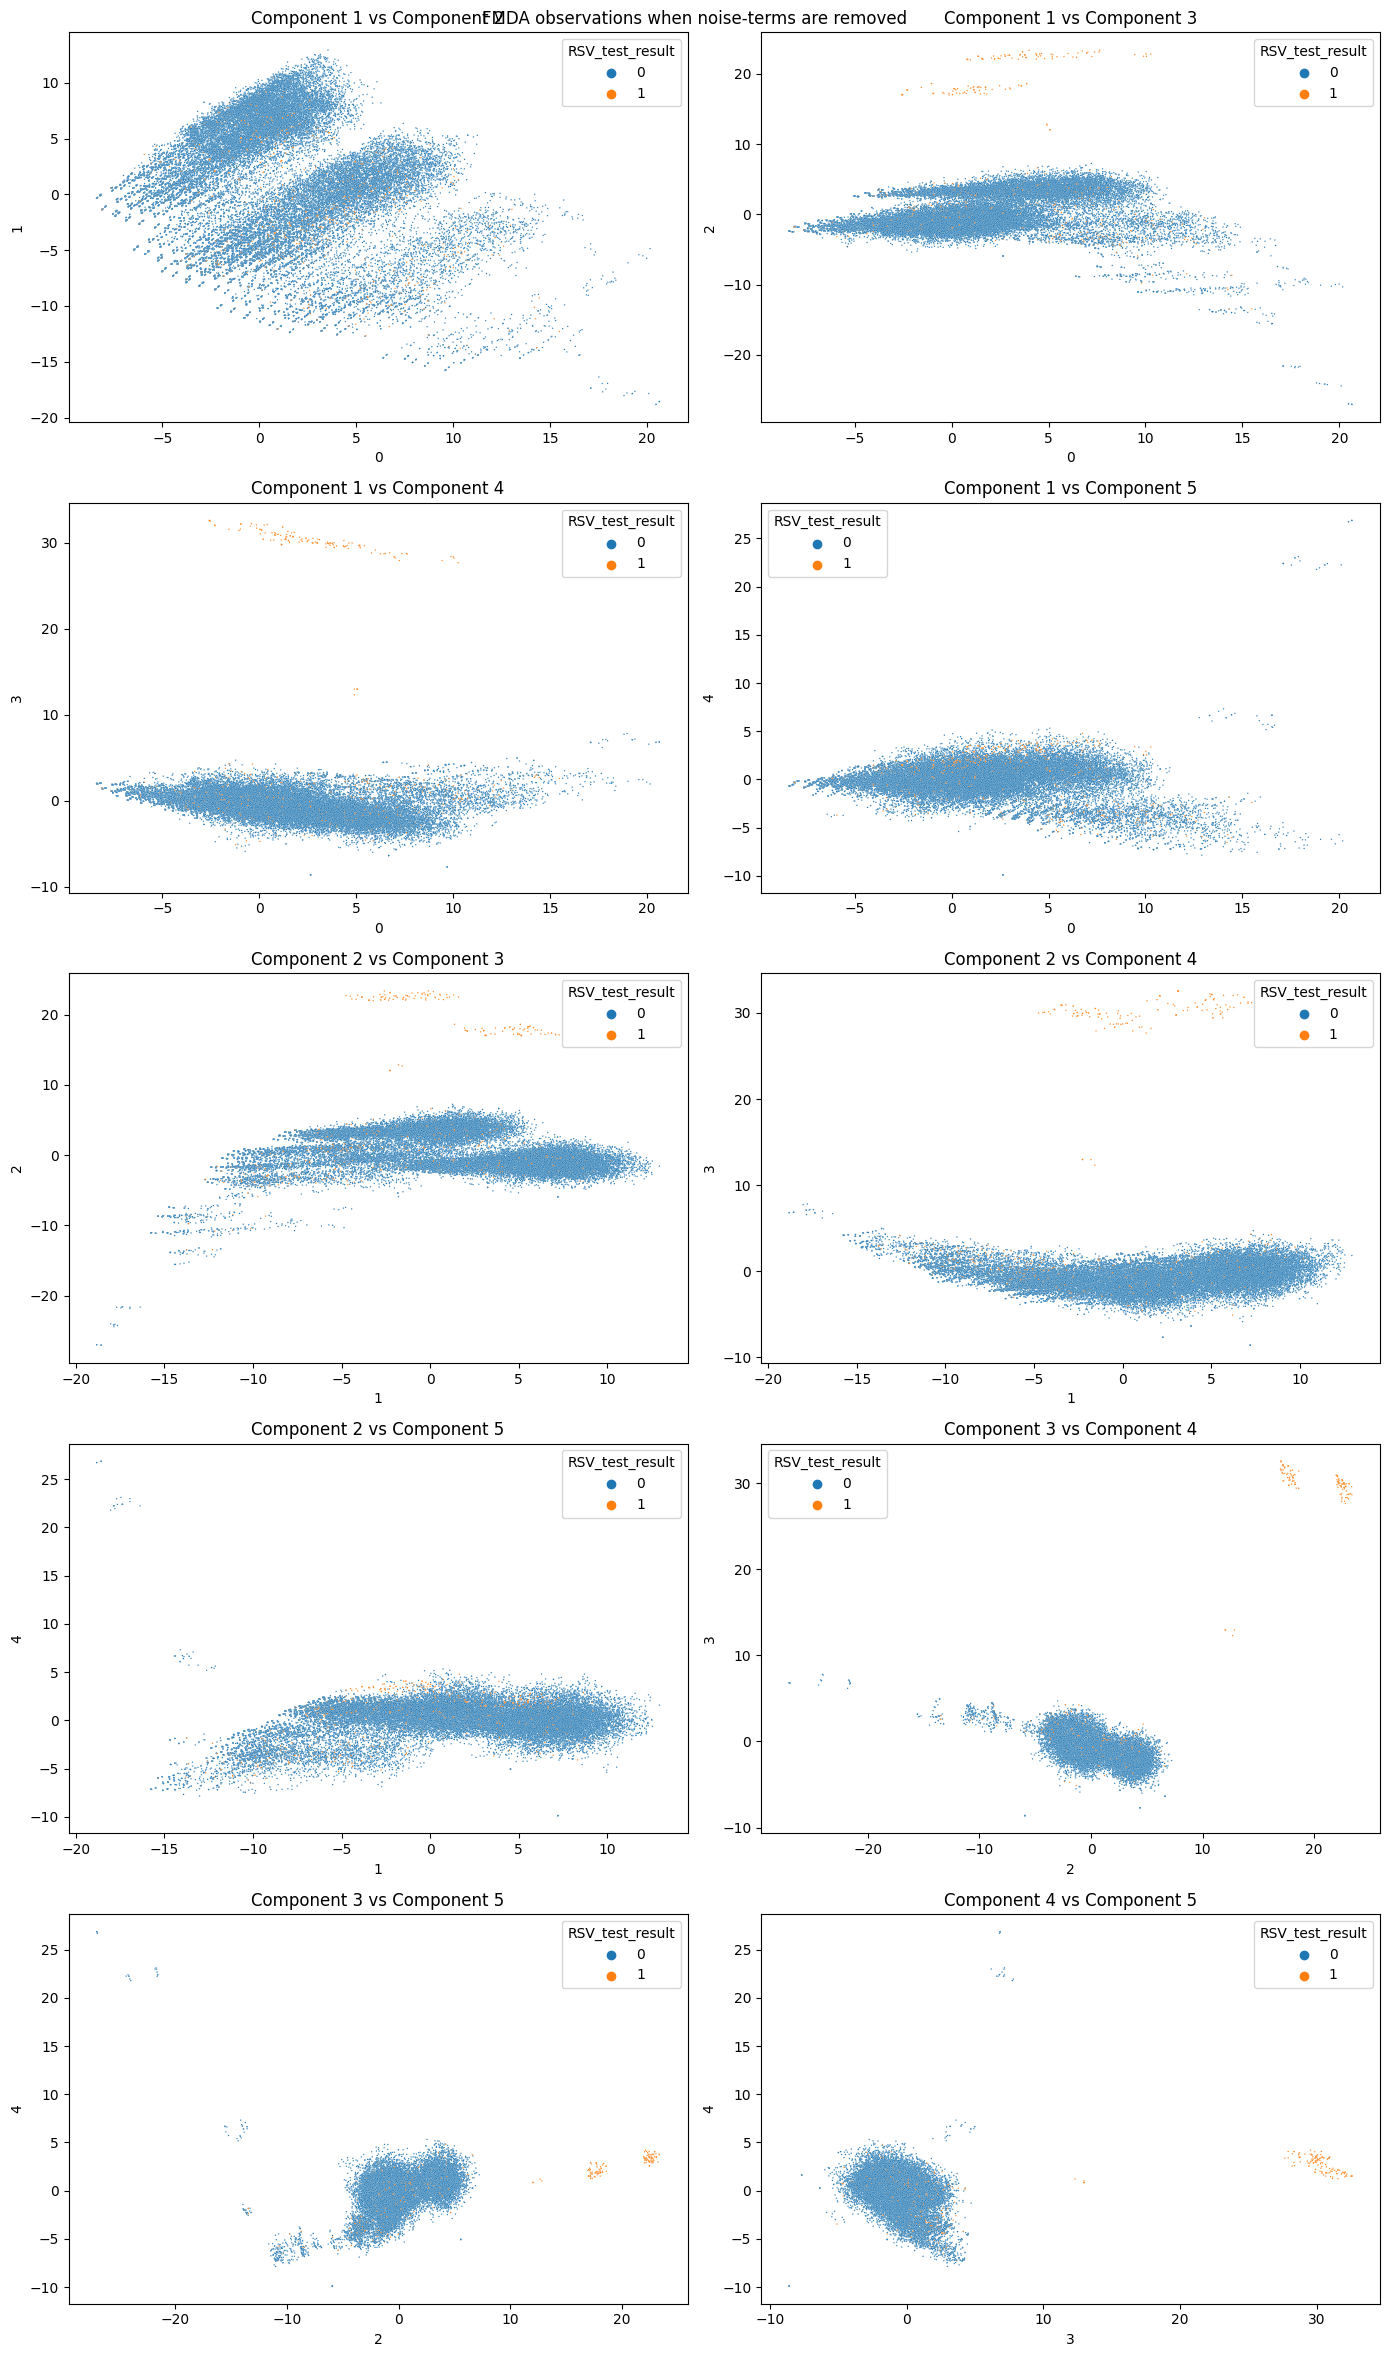

In [39]:
df_transformed['is_noise'] = df_transformed['DBSCAN_labels'].apply(lambda x: 'Noise' if x == -1 else 'Clustered')

# Evaluate the number of positive records in the clustered and noise regions:
print('-----------')
total_pos = df_transformed['RSV_test_result'].value_counts()[1]
print(f'Total number of positive records: {total_pos}')
for c in df_transformed['is_noise'].unique():
    aux_df = df_transformed.loc[df_transformed['is_noise'] == c]
    pos = aux_df['RSV_test_result'].value_counts()[1]
    print(f'Number of positives in {c}: {pos}')

    
# Plot of noise and clustered observations
plot_5FMDA_planes(df = df_transformed, hue_target = 'is_noise', palette = {"Clustered": "g", "Noise": "r"}, main_title = 'FMDA + DBSCAN: noise and clustered observations')

# Plot the labels when the noise observations are removed:
df_no_noise = df_transformed.loc[df_transformed['is_noise'] != 'Noise']
plot_5FMDA_planes(df = df_no_noise, hue_target = 'RSV_test_result', main_title = 'FMDA observations when noise-terms are removed')


In [40]:
count_pos = 0
count_neg = 0
count_mix = 0
for cl in df_no_noise['DBSCAN_labels'].unique():
    # print(f'Cluster {cl}')
    aux_df = df_transformed.loc[df_transformed['DBSCAN_labels'] == cl]
    neg = aux_df['RSV_test_result'].value_counts().iloc[0]
    
    if len(aux_df['RSV_test_result'].value_counts()) > 1:
        pos = aux_df['RSV_test_result'].value_counts().iloc[1]
        pos_to_neg = pos / neg
        # print(f'Positive to negative ratio: {pos_to_neg}')
        count_mix += 1
        df_transformed.loc[df_transformed['DBSCAN_labels'] == cl, 'mixed_or_unique'] = 'Mixed'

    else: 
        dominant_label = aux_df['RSV_test_result'].value_counts().index[0]
        if dominant_label == 1:
            # print('Fully positive')
            df_transformed.loc[df_transformed['DBSCAN_labels'] == cl, 'mixed_or_unique'] = 'Positive'
            count_pos += 1
        elif dominant_label == 0:
            # print('Fully negative')
            df_transformed.loc[df_transformed['DBSCAN_labels'] == cl, 'mixed_or_unique'] = 'Negative'
            count_neg += 1
print('-------------')
print('Results of DBSCAN clustering:')
print(f'\n# fully positive clusters: {count_pos}')
pos_obs = df_transformed['mixed_or_unique'].value_counts()['Positive']
print(f'observacions on fully positive: {pos_obs}')

print(f'\n# fully negative clusters: {count_neg}')
neg_obs = df_transformed['mixed_or_unique'].value_counts()['Negative']
print(f'observacions on fully negative: {neg_obs}')

print(f'\n# mixed clusters: {count_mix}')
mix_obs = df_transformed['mixed_or_unique'].value_counts()['Mixed']
print(f'observacions on mixed clusters: {mix_obs}')

-------------
Results of DBSCAN clustering:

# fully positive clusters: 13
observacions on fully positive: 147

# fully negative clusters: 128
observacions on fully negative: 775

# mixed clusters: 26
observacions on mixed clusters: 65187


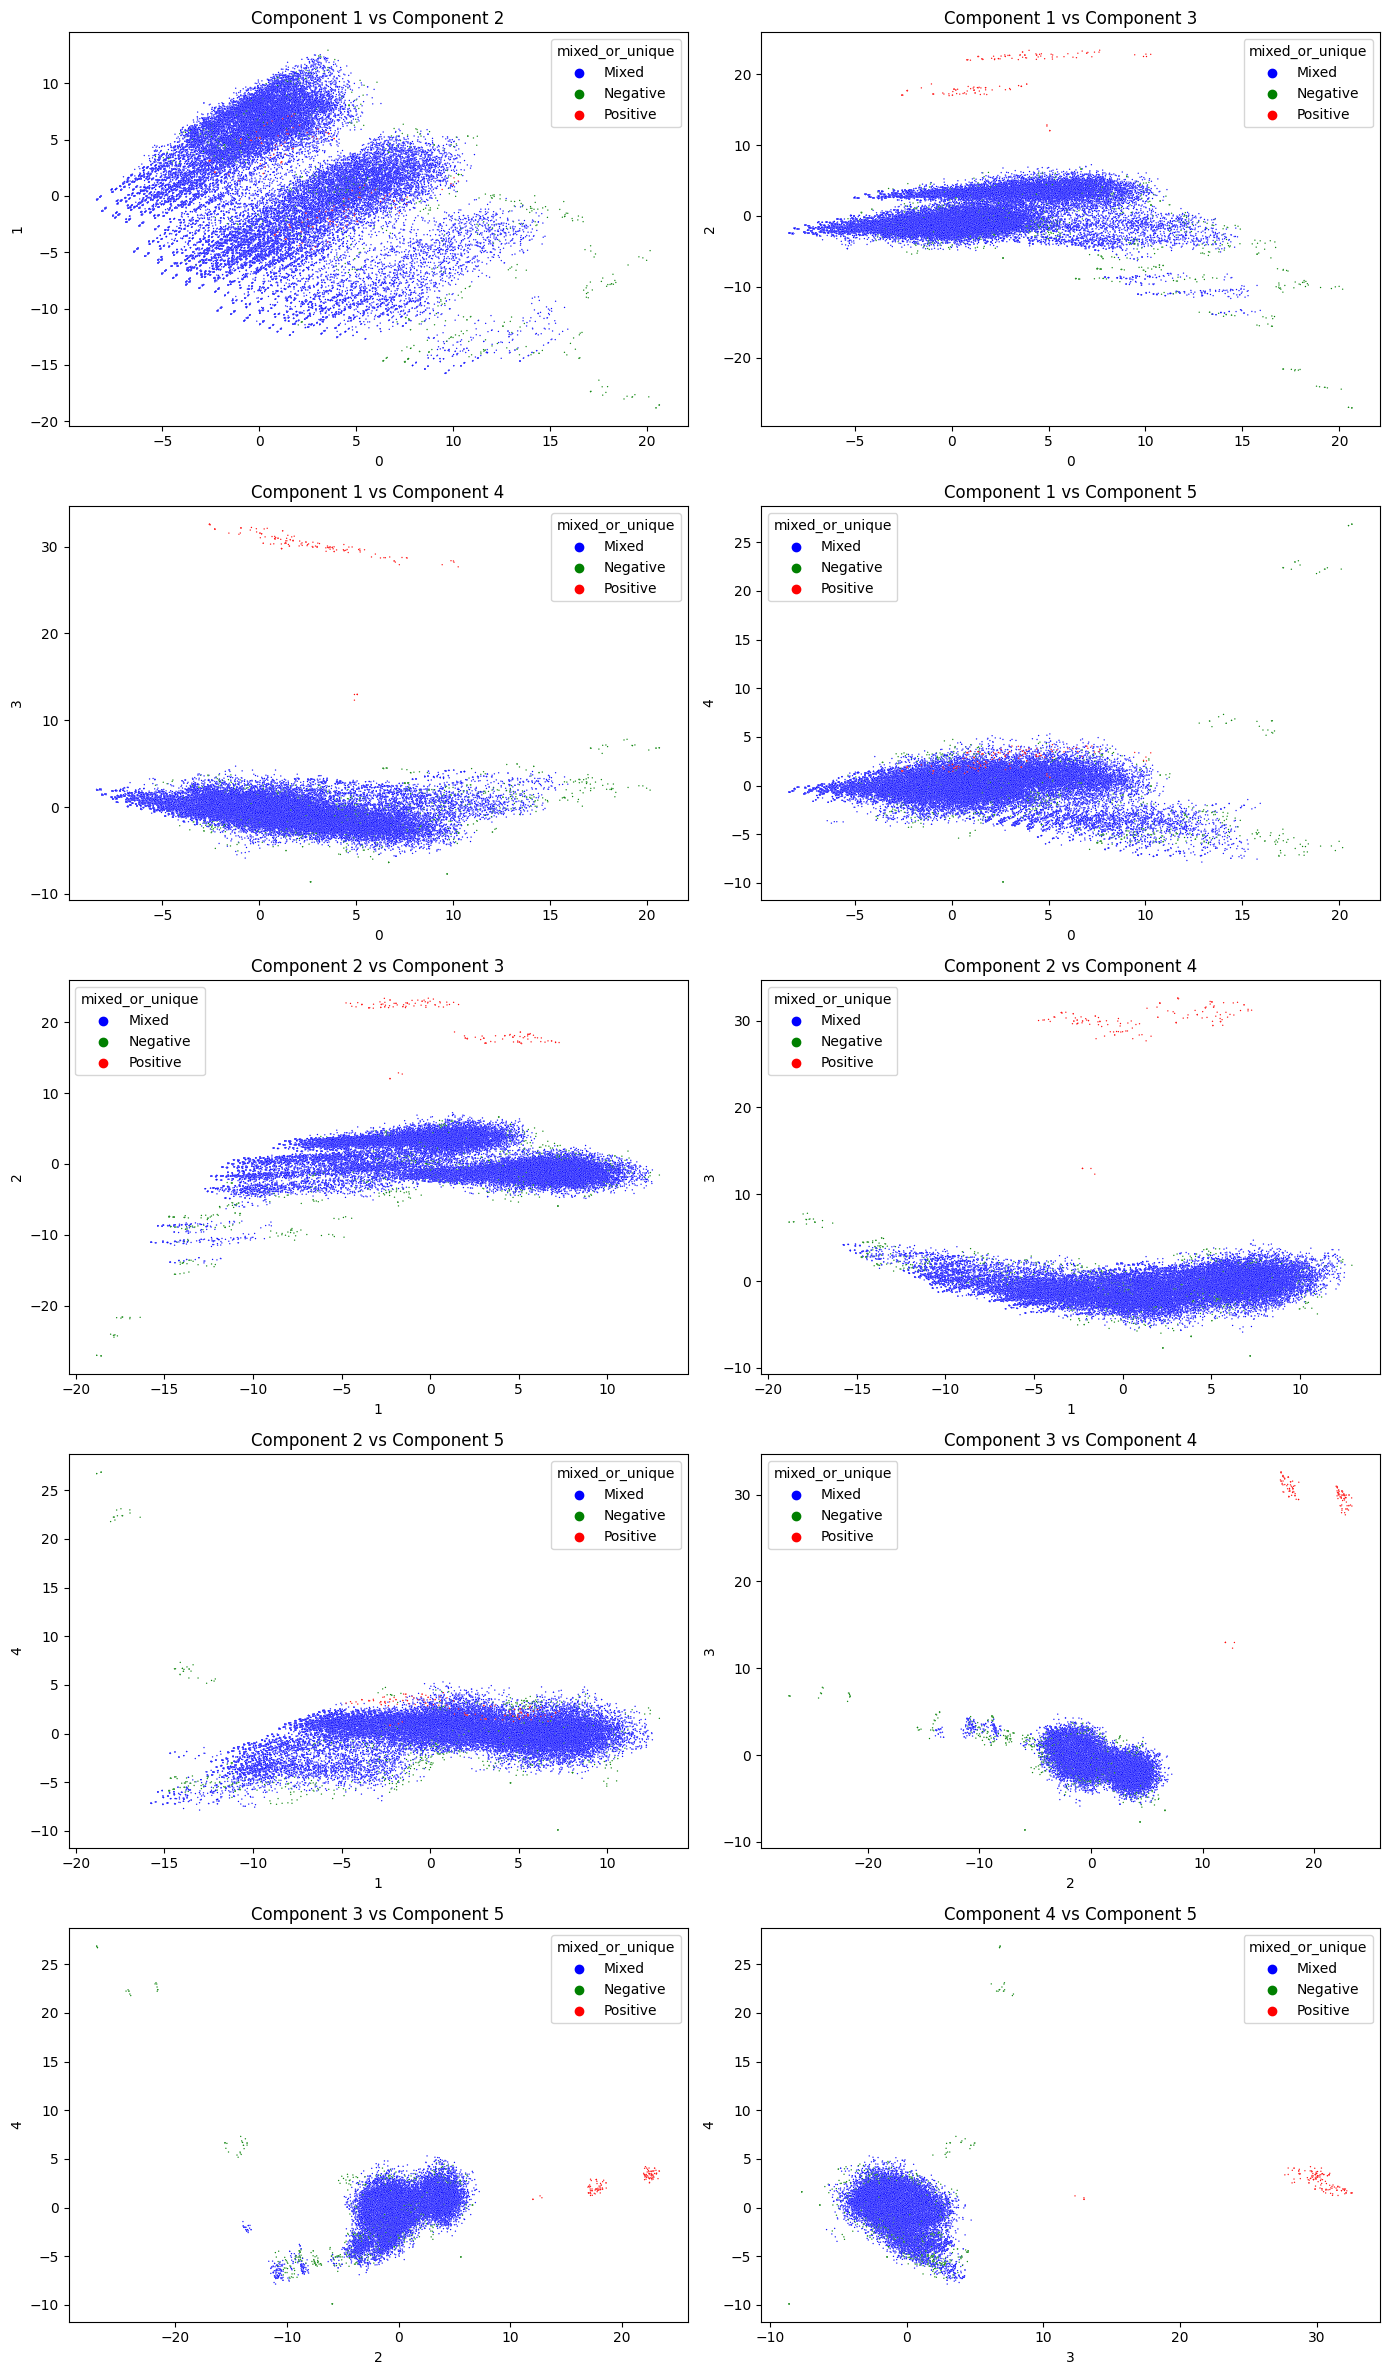

In [42]:
df_no_noise = df_no_noise.assign(mixed_or_unique=df_transformed.loc[df_transformed['is_noise'] != 'Noise', 'mixed_or_unique'].values)
plot_5FMDA_planes(df = df_no_noise, hue_target = 'mixed_or_unique', palette = {'Mixed': 'b', 'Positive': 'r', 'Negative': 'g'})

This analysis results in 65187 points (98% of no noise points) to be in an overlapping region. This is a extremely heavy class overlap, that aligns with the classification results we have been obtaining [4]: 

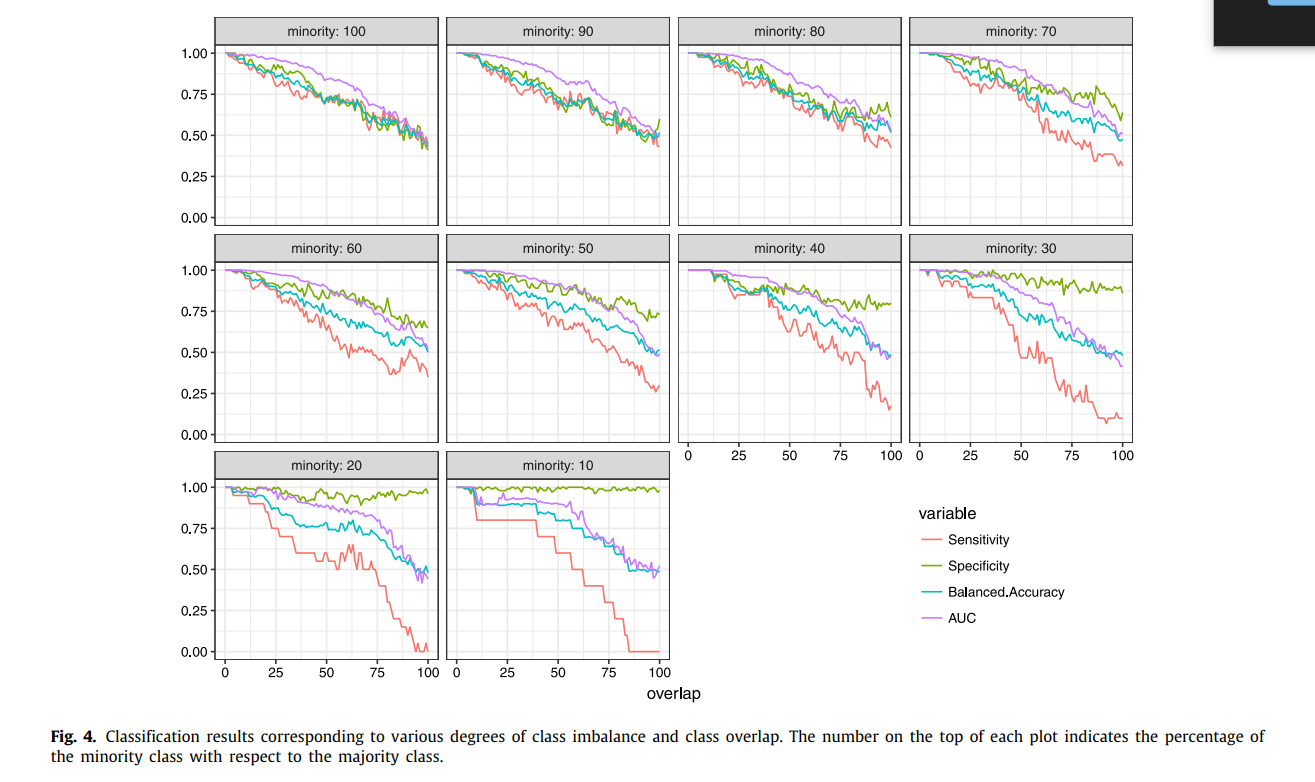

[4] Vuttipittayamongkol, P., Elyan, E., & Petrovski, A. (2021). On the class overlap problem in imbalanced data classification. Knowledge-based systems, 212, 106631.